# CMPT 419 Final Project - Object Related Affect

## Setup and Pre-processing

In [77]:
import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
#os.chdir("drive/My Drive")

We can remove the rows with low confidence and unsuccessful images. Unsuccessful images are both those that OpenFace could not recognize a face in, as well as ones that we removed due to having multiple faces present.  

We also removed the features for 2D and 3D landmarks, as well as rigid and non-rigid shape parameters. We kept features relating to AUs, eye gaze, head movement, and the bounding box of the object. More information on the features can be found at https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format. 


In [78]:
# Filter out low confidence and unsuccessful entries
df = pd.read_csv('train_cleaned.csv')
df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True)
df.columns = df.columns.str.replace(' ', '')
df = df[df.confidence>=.80]
df = df[df.success == 1]
df.dropna(how='any')

# Select relevant features
main_cols = ['confidence', 'success', 'emotion', 'intensity']
aus = df.columns[df.columns.str.contains('\d_r', regex=True)]
# NOTE: may want to look at gaze vectors too?
gaze = df.columns[df.columns.str.contains('gaze_angle')]
eye = df.columns[df.columns.str.contains('eye')]
pose = df.columns[df.columns.str.contains('pose')]

# Filter irrelevant features out of dataframe 
needed = aus.append([gaze, pose])
needed_cols = [col for col in df.columns if col in needed or col in main_cols]
df = df[needed_cols]
df.head()

,confidence,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion,intensity,success
0,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.60,0.67,0,1.84,0.33,0.00,0,0,0,0,0,0,0,happy,2,1
1,0.98,-0.052,0.541,14.6,-70.7,396.7,0.369,0.042,0.141,0,0,0.56,0,2.66,3.01,0,1.10,0.94,2.16,0,0,0,0,0,0,0,happy,5,1
3,0.98,-0.358,0.082,84.7,-41.9,528.9,-0.024,0.443,0.094,0,0,1.16,0,0.00,0.00,0,0.69,0.48,0.00,0,0,0,0,0,0,0,happy,2,1
4,0.98,-0.147,0.251,3.1,-244.3,1628.0,0.263,0.224,-0.058,0,0,0.00,0,0.00,0.00,0,0.71,0.00,0.00,0,0,0,0,0,0,0,happy,2,1
5,0.88,-0.314,0.248,-27.4,-102.9,1073.5,0.219,0.508,-0.090,0,0,1.02,0,0.00,0.00,0,1.71,0.00,2.00,0,0,0,0,0,0,0,disgust,1,1


To start, we can just look at entries as happy or not happy.

In [79]:
df.emotion[df.emotion == 'happy'] = 1
df.emotion[df.emotion != 1] = 0
df.rename(columns={'emotion': 'is_happy'}, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,confidence,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,is_happy,intensity,success
0,0.98,0.408,0.486,226.2,-247.6,991.0,0.546,-0.698,0.215,0,0,1.17,0,0.60,0.67,0,1.84,0.33,0.00,0,0,0,0,0,0,0,1,2,1
1,0.98,-0.052,0.541,14.6,-70.7,396.7,0.369,0.042,0.141,0,0,0.56,0,2.66,3.01,0,1.10,0.94,2.16,0,0,0,0,0,0,0,1,5,1
3,0.98,-0.358,0.082,84.7,-41.9,528.9,-0.024,0.443,0.094,0,0,1.16,0,0.00,0.00,0,0.69,0.48,0.00,0,0,0,0,0,0,0,1,2,1
4,0.98,-0.147,0.251,3.1,-244.3,1628.0,0.263,0.224,-0.058,0,0,0.00,0,0.00,0.00,0,0.71,0.00,0.00,0,0,0,0,0,0,0,1,2,1
5,0.88,-0.314,0.248,-27.4,-102.9,1073.5,0.219,0.508,-0.090,0,0,1.02,0,0.00,0.00,0,1.71,0.00,2.00,0,0,0,0,0,0,0,0,1,1


Split the dataset into train and test sets.

In [80]:
X = df.drop('is_happy', 1)
y = df.is_happy.astype('bool')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Selection

Next we can start exploring different classification models. We can start with a basic decision tree classifier and return the accuracy and F1 score.

In [81]:
#Initialize the classifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train,y_train)

#Get the predictions and accuracy
y_pred = dt.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary'))

Accuracy: 0.6774193548387096
F1 Score: 0.7916666666666666


Next we can visualize the decision tree. 

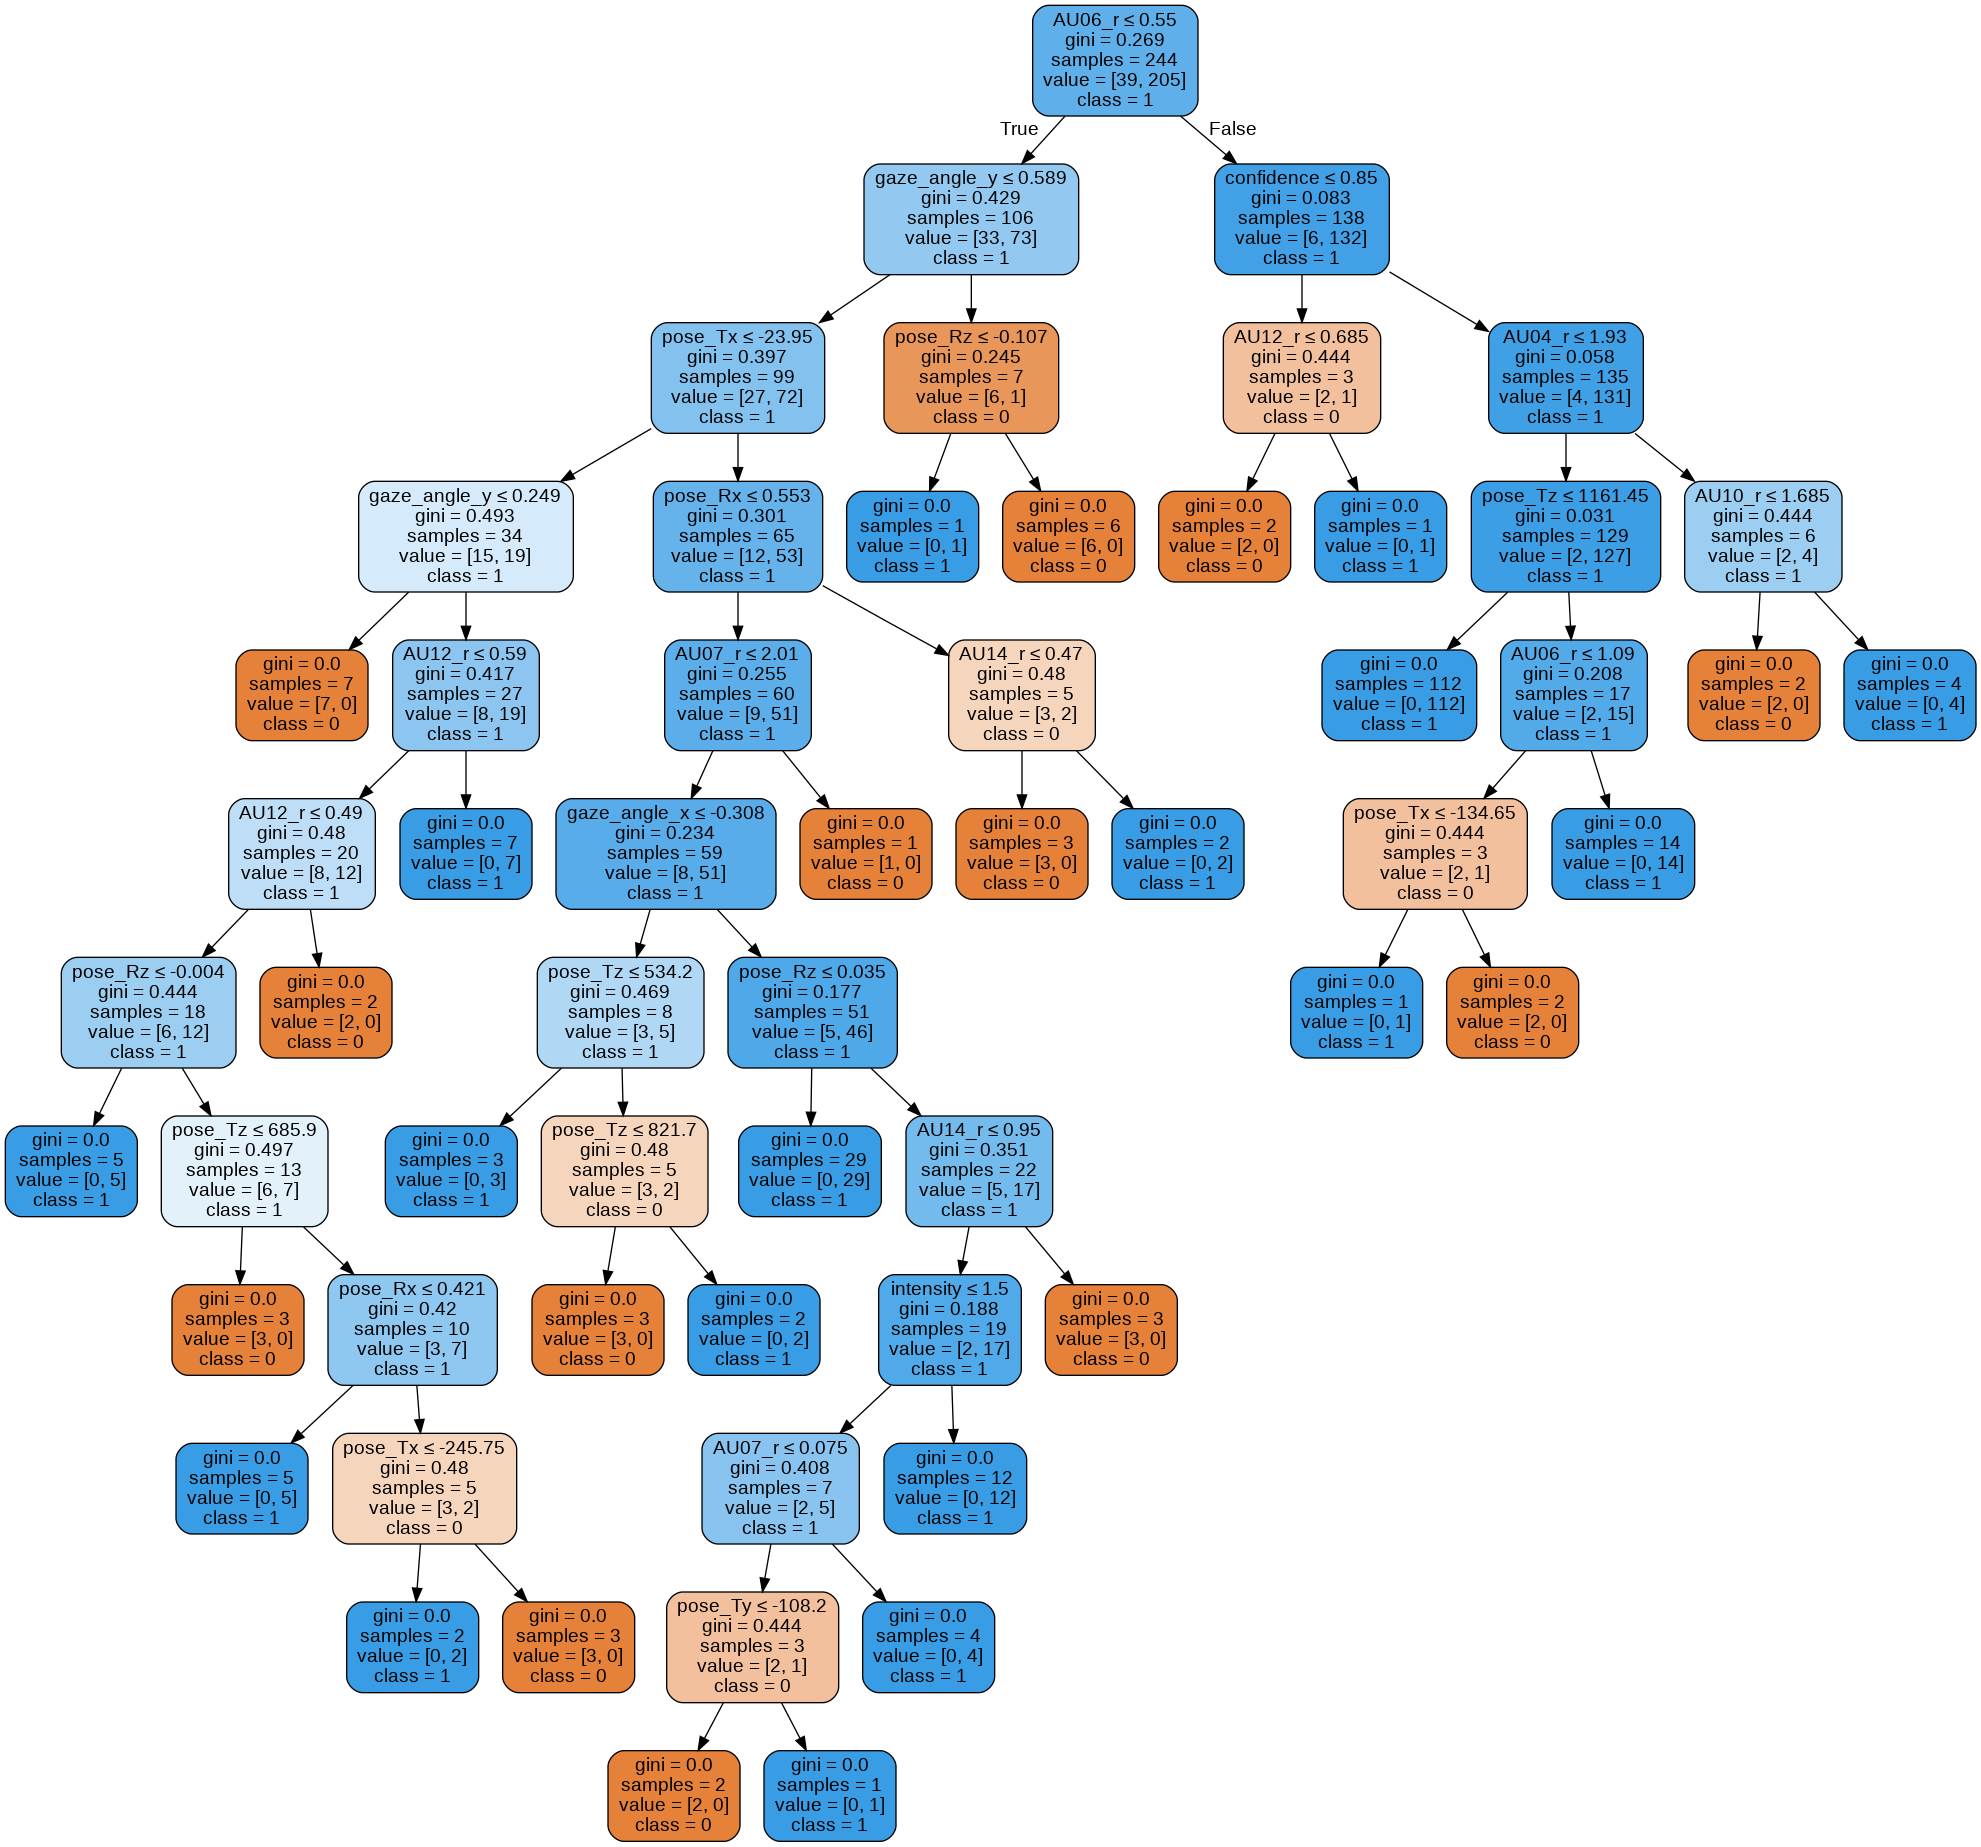

In [89]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

Given the depth of the tree, it may be overfitting.

The next model to try is Random Forest. Random Forest selects random samples from the dataset, creates a decision tree, gets a prediction from the tree, votes for each result, and then selects the prediction with the most votes as the final result. Because of the voting process, it is not as prone to overfitting since it takes the average of all predictions. 

In [92]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)

rf = rf.fit(X_train,y_train)

#Get the predictions and accuracy
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='binary'))

Accuracy: 0.7903225806451613
F1 Score: 0.882882882882883


Next we can take a look at the most important features. We may want to only include a subset of the most important features in future models to get rid of noise.

In [93]:
importance = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
importance

pose_Rx         0.085310
gaze_angle_y    0.080547
AU12_r          0.080323
pose_Ty         0.077843
gaze_angle_x    0.072732
pose_Tx         0.069494
pose_Rz         0.067128
AU06_r          0.064090
pose_Ry         0.062204
AU04_r          0.060236
AU14_r          0.056989
intensity       0.053630
pose_Tz         0.045983
AU10_r          0.043809
confidence      0.041545
AU07_r          0.038137
AU05_r          0.000000
AU02_r          0.000000
AU01_r          0.000000
AU09_r          0.000000
AU15_r          0.000000
AU17_r          0.000000
AU20_r          0.000000
AU23_r          0.000000
AU25_r          0.000000
AU26_r          0.000000
AU45_r          0.000000
success         0.000000
dtype: float64